In [ ]:
 !apt-get install tesseract-ocr -y
 !apt-get install libtesseract-dev -y
 !apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (10.6 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [ ]:
!pip install langchain unstructured[all-docs] pydantic lxml openai faiss-cpu tiktoken opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.4/246.4 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 59.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.4 MB

In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

In [3]:
output_path = "./images"

# Get elements from pdf
raw_pdf_elements = partition_pdf(
    filename = "/content/Phase-4-Documentation.pdf",
    extract_images_in_pdf = True,
    extract_table_structure = True,
    chunking_strategy = "by_title",
    max_characters = 4000,
    new_after_n_chars = 3800,
    combine_text_under_n_chars = 2000,
    extract_image_block_output_dir= output_path
)

In [4]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [5]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a AI assistant that is good at analyzing images. The images are related to Microsoft Teams."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4-vision-preview", openai_api_key=openai_api_key, max_tokens=512).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)


In [27]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))


In [28]:
vectorstore.save_local("faiss_index")

In [36]:
prompt_template = """
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [37]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-4", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [38]:
def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        print(d)
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [39]:
# Display result
result, relevant_images = answer("Bi-LSTM")
print(result)

page_content='The image depicts a diagram of a Bidirectional Long Short-Term Memory (BiLSTM) neural network architecture. This type of network is a variant of Recurrent Neural Networks (RNNs) that can capture dependencies in both forward and backward directions of a sequence.\n\nHere are the components of the diagram:\n\n1. There are three columns, each representing a time step in the sequence of data: time step t-1, time step t, and time step t+1.\n\n2. Each column has two LSTM blocks, one in the "Forward Layer" and one in the "Backward Layer," indicating that the network processes the sequence data in both directions.\n\n3. The forward LSTM blocks process the sequence from left to right (from earlier to later time steps), while the backward LSTM blocks process the sequence from right to left (from later to earlier time steps).\n\n4. The inputs to the LSTMs at each time step are denoted as x_t-1, x_t, and x_t+1.\n\n5. The LSTMs produce hidden state outputs represented as h̃_t-1, h̃_t,

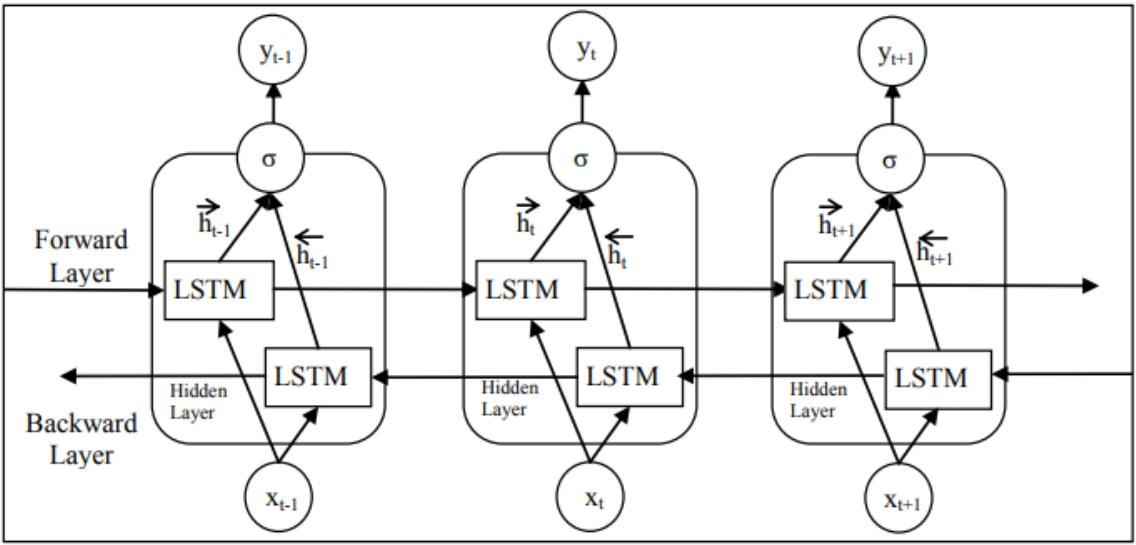

In [40]:
for e in relevant_images:
    display.display(display.Image(base64.b64decode(e)))

In [41]:
# Display result
result, relevant_images = answer("Proposed architecture of LSTM?")
print(result)

page_content='The text discusses the use of Bi-directional Long Short-Term Memory (LSTM) networks for text sequence prediction and classification, as well as a proposed fake news detection model based on LSTMs. The model involves splitting news articles into words, tokenizing them, and using a Word2Vec model for semantic analysis. The text also presents the architecture and results of an LSTM model for fake news detection.' metadata={'id': '0a85995d-1088-4173-ac36-7e4295cf21d6', 'type': 'text', 'original_content': '4.4. Bi-directional Long Short-Term Memory - RNN:\n\nthrough time and in lower layers of a deep network [19]. Bi-directional processing is an evident approach for a large text sequence prediction and text classification. As shown in below figure, a Bi-Directional LSTM network steps through the input sequence in both directions at the same time.\n\nBackward Layer\n\nGeneral architecture of Bi-directional LSTM- RNN [2]\n\n4.5. Proposed Work:\n\nThe proposed fake news detection

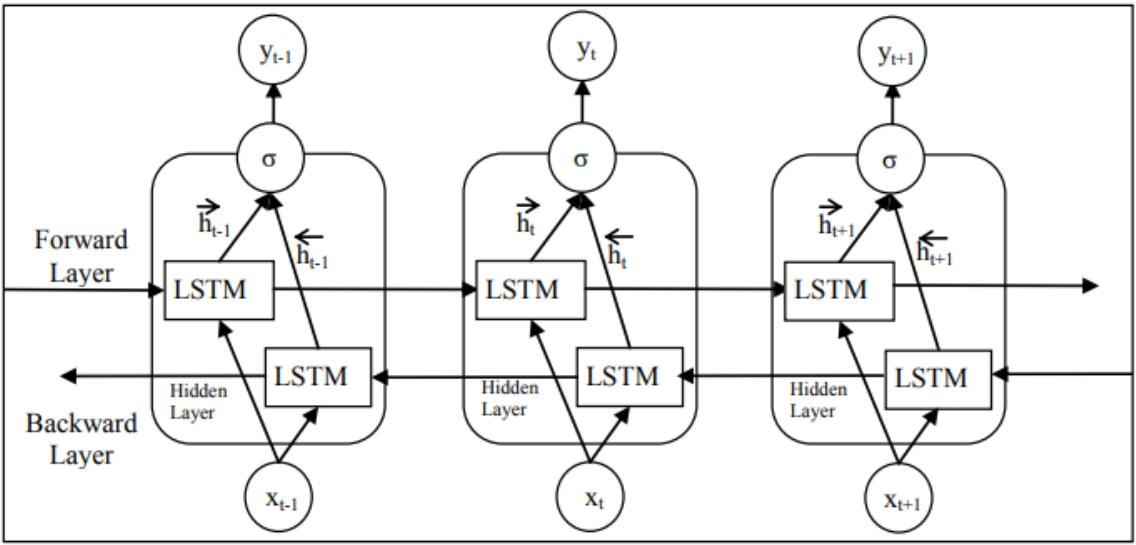

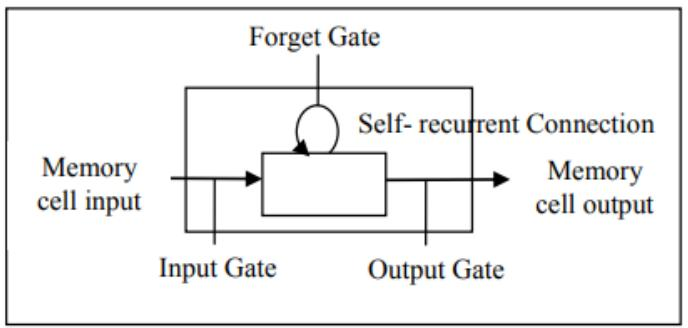

In [42]:
for e in relevant_images:
    display.display(display.Image(base64.b64decode(e)))

In [18]:
import uuid

from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

# Initialize the vector store and storage layer
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings(openai_api_key=openai_api_key))
store = InMemoryStore()
id_key = "doc_id"

# Initialize the retriever
retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=store, id_key=id_key)

# Function to add documents to the retriever
def add_documents_to_retriever(summaries, original_contents):
    doc_ids = [str(uuid.uuid4()) for _ in summaries]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, original_contents)))

In [19]:
# Add text summaries
add_documents_to_retriever(text_summaries, text_elements)

# Add table summaries
add_documents_to_retriever(table_summaries, table_elements)

# Add image summaries
add_documents_to_retriever(image_summaries, image_summaries) # hopefully real images soon

In [20]:
# We can retrieve this table
retriever.get_relevant_documents(
    "Explain Bi-LSTM?"
)

['The image depicts a diagram of a Bidirectional Long Short-Term Memory (BiLSTM) neural network architecture. This type of network is a variant of Recurrent Neural Networks (RNNs) that can capture dependencies in both forward and backward directions of a sequence.\n\nHere are the components of the diagram:\n\n1. There are three columns, each representing a time step in the sequence of data: time step t-1, time step t, and time step t+1.\n\n2. Each column has two LSTM blocks, one in the "Forward Layer" and one in the "Backward Layer," indicating that the network processes the sequence data in both directions.\n\n3. The forward LSTM blocks process the sequence from left to right (from earlier to later time steps), while the backward LSTM blocks process the sequence from right to left (from later to earlier time steps).\n\n4. The inputs to the LSTMs at each time step are denoted as x_t-1, x_t, and x_t+1.\n\n5. The LSTMs produce hidden state outputs represented as h̃_t-1, h̃_t, and h̃_t+1 